# Spike Gadgets Ephys and Video Syncing

In [1]:
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings
import os

In [2]:
import numpy as np
import pandas as pd
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [6]:
np.random.seed(seed=42)

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [7]:
protocol_name = "rc_extention"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [8]:
input_folder = "./data"

In [9]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [10]:
raw_data_glob_pattern = "/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [11]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [12]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [13]:
glob.glob(os.path.join(raw_data_file_path, "*"))

['/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.rec',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.2.trackgeometry',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.1.videoTimeStamps.cameraHWSync',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.rec/20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.raw',
 '/scratch/back_up/reward_competition_extention/data/omission/2023_06_18/20230618_100636_standard_comp_to_omissio

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [18]:
file_to_data = trodes.read_exported.organize_all_trodes_export(raw_data_file_path)

Skipping file 20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged.timestampoffset.txt due to error: Settings format not supported
Skipping file 20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.timestampoffset.txt due to error: Settings format not supported


- All the folders that were extracted from

In [19]:
file_to_data.keys()

dict_keys(['20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged', '20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged'])

In [21]:
for file_name in file_to_data.keys():
    print(file_name)

20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
20230618_100636_standard_comp_to_omission_D2_subj_1_4_t4b3L_box1_merged


- Looking over all the extracted data

In [23]:
for key, value in file_to_data.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict.items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            # print("\t \t Data Value: {}".format(data_value))

Directory: 20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged
	File Name: raw

 	 	 Trodes Data Type: raw_group0
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: coordinates
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: timestamps
	 	 Python Type: <class 'dict'>
	File Name: DIO

 	 	 Trodes Data Type: dio_ECU_Dout3
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: dio_ECU_Din1
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: dio_ECU_Dout1
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: dio_ECU_Din4
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: dio_ECU_Dout4
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: dio_ECU_Din3
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: dio_ECU_Dout2
	 	 Python Type: <class 'dict'>

 	 	 Trodes Data Type: dio_ECU_Din2
	 	 Python Type: <class 'dict'>
	File Name: analog

 	 	 Trodes Data Type: timestamps
	 	 Python Type: <class 'dict'>
	File Name: time

 	 	 Trodes Data Type: 

# Part 2: Looking over the data

## Looking over the ephys recording

- Getting the name of the ephys recording directory

In [28]:
subj_1_key = list(file_to_data.keys())[0]
subj_2_key = list(file_to_data.keys())[-1]


In [29]:
raw_directory_dict = file_to_data[subj_1_key]["raw"]

- Getting the name of the files in the ephys recording directory

In [30]:
raw_directory_dict.keys()

dict_keys(['raw_group0', 'coordinates', 'timestamps'])

In [32]:
raw_recording_fields_text = raw_directory_dict["raw_group0"]

In [33]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20230618_100636_standard_comp_to_omission_D2_subj_1_1_t1b2L_box2_merged.rec',
 'clockrate': '20000',
 'trodes_version': '2.4.0',
 'compile_date': 'May 24 2023',
 'compile_time': '10:11:04',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.4.0-0-g1eecf3b7',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00129',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '0',
 'time_offset': '0',
 'system_time_at_creation': '1687097219606',
 'timestamp_at_creation': '489210',
 'first_timestamp': '835680',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([-600, -504, -547, -973, -731, -587, -222, -668, -476, -525, -536, -565, -707, -654, -724, -932, -632, -985, -795, -722, -537, 

- Array of Voltages for each channel

In [34]:
voltage_value_array = raw_recording_fields_text["data"]

In [35]:
voltage_value_array.shape

(65603942,)

In [36]:
voltage_value_array[0]

([-600, -504, -547, -973, -731, -587, -222, -668, -476, -525, -536, -565, -707, -654, -724, -932, -632, -985, -795, -722, -537, -387, -504, -547, -654, -415, -457, -543,   11, -102, -415,   -8],)

In [37]:
len(voltage_value_array[0][0])

32

In [38]:
voltage_value_array[:5]

array([([-600, -504, -547, -973, -731, -587, -222, -668, -476, -525, -536, -565, -707, -654, -724, -932, -632, -985, -795, -722, -537, -387, -504, -547, -654, -415, -457, -543,   11, -102, -415,   -8],),
       ([-606, -517, -602, -852, -733, -599, -239, -570, -490, -531, -456, -495, -703, -696, -656, -887, -644, -867, -687, -645, -430, -409, -452, -467, -632, -407, -353, -488,   47,  -65, -386,   40],),
       ([-490, -528, -540, -774, -669, -530, -234, -642, -613, -489, -493, -484, -644, -575, -590, -842, -547, -891, -708, -700, -437, -407, -454, -429, -629, -382, -432, -504,   -7,  -35, -414,   83],),
       ([-512, -491, -561, -736, -596, -445, -200, -618, -522, -399, -543, -401, -599, -612, -564, -750, -560, -897, -735, -677, -416, -340, -424, -398, -525, -362, -257, -469,  -18,  -60, -396,  116],),
       ([-485, -579, -470, -776, -637, -490, -232, -513, -511, -410, -615, -489, -574, -633, -579, -727, -499, -822, -646, -633, -488, -328, -359, -413, -540, -446, -365, -420, -104,  

- Voltage Time Stamps

In [39]:
raw_directory_dict.keys()

dict_keys(['raw_group0', 'coordinates', 'timestamps'])

In [41]:
voltage_timestamp_array = raw_directory_dict["timestamps"]["data"]

In [42]:
voltage_timestamp_array[:5]

array([(835680,), (835681,), (835682,), (835683,), (835684,)],
      dtype=[('time', '<u4')])

In [43]:
voltage_timestamp_array[-5:]

array([(66439617,), (66439618,), (66439619,), (66439620,), (66439621,)],
      dtype=[('time', '<u4')])

In [44]:
voltage_timestamp_array.shape

(65603942,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [45]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [46]:
voltage_timestamp_array[:5]

array([835680, 835681, 835682, 835683, 835684])

In [47]:
voltage_timestamp_array[-5:]

array([66439617, 66439618, 66439619, 66439620, 66439621])

In [48]:
voltage_timestamp_array.shape

(65603942,)

# Part 3: Converting everything into timestamps

## Voltage to timestamp

- Use the matching index to convert between the voltage time stamp and the recording

In [50]:
voltage_index = 0

In [51]:
voltage_value_array[voltage_index]

([-600, -504, -547, -973, -731, -587, -222, -668, -476, -525, -536, -565, -707, -654, -724, -932, -632, -985, -795, -722, -537, -387, -504, -547, -654, -415, -457, -543,   11, -102, -415,   -8],)

- Getting the associated timestamp of the ephys recording

In [52]:
voltage_timestamp_array[:5]

array([835680, 835681, 835682, 835683, 835684])

In [53]:
voltage_timestamp_array[-5:]

array([66439617, 66439618, 66439619, 66439620, 66439621])

In [54]:
voltage_time_stamp = voltage_timestamp_array[voltage_index]

In [55]:
voltage_time_stamp

835680

# Part 4: Converting from timestamps back to everything

In [56]:
def timestamp_to_index(current_ts, ts_array):
    """
    """
    return np.argwhere(ts_array >= current_ts)[0][0]

## Time stamp to Voltage Value

In [57]:
voltage_timestamp_array

array([  835680,   835681,   835682, ..., 66439619, 66439620, 66439621])

In [58]:
voltage_timestamp_array[0]

835680

- Getting the index of the closest timestamp 

In [59]:
random_voltage_index = timestamp_to_index(current_ts=voltage_timestamp_array[0], ts_array=voltage_timestamp_array)

In [60]:
random_voltage_index

0

- Checking if it matches to the original timestamp
    - Should be the same, because the sampling rate of the timestamps are based on the ephys recording

In [61]:
voltage_timestamp_array[random_voltage_index]

835680

- Getting the voltage value based on the index

In [62]:
voltage_value_array[random_voltage_index]

([-600, -504, -547, -973, -731, -587, -222, -668, -476, -525, -536, -565, -707, -654, -724, -932, -632, -985, -795, -722, -537, -387, -504, -547, -654, -415, -457, -543,   11, -102, -415,   -8],)

# ADDED AFTER

# Part 4: Syncing everything based on timestamps

# Syncing with MED-PC

## Looking over the MED-PC Data

- Box 1 Port Entries
    - ECU Din3
- Box 2 Port Entries
    - Controller Din1
- Box 1 Tone playing
    - ECU Din1

### Tone Onset Signal

In [67]:
tone_onset_DIN_state_array = file_to_data[subj_1_key]["DIO"]["dio_ECU_Din1"]["data"]

In [68]:
tone_onset_DIN_state_array

array([(  835680, 0), ( 1934930, 1), ( 2134930, 0), ( 4334936, 1),
       ( 4534932, 0), ( 6634931, 1), ( 6834928, 0), ( 8434930, 1),
       ( 8634927, 0), ( 9534930, 1), ( 9734927, 0), (10534929, 1),
       (10734926, 0), (12434926, 1), (12634925, 0), (13934925, 1),
       (14134925, 0), (16034924, 1), (16234926, 0), (17034926, 1),
       (17234926, 0), (18634925, 1), (18834923, 0), (19934925, 1),
       (20134924, 0), (21234922, 1), (21434924, 0), (22234924, 1),
       (22434924, 0), (23634923, 1), (23834923, 0), (25534923, 1),
       (25734920, 0), (27134920, 1), (27334922, 0), (28534922, 1),
       (28734919, 0), (30734921, 1), (30934918, 0), (31934918, 1),
       (32134918, 0), (37934919, 1), (38134919, 0), (39134916, 1),
       (39334916, 0), (40234916, 1), (40434915, 0), (41534918, 1),
       (41734915, 0), (42634918, 1), (42834917, 0), (43634915, 1),
       (43834917, 0), (44634917, 1), (44834914, 0), (46734914, 1),
       (46934916, 0), (49134915, 1), (49334913, 0), (51534912,

(array([39.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 38.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

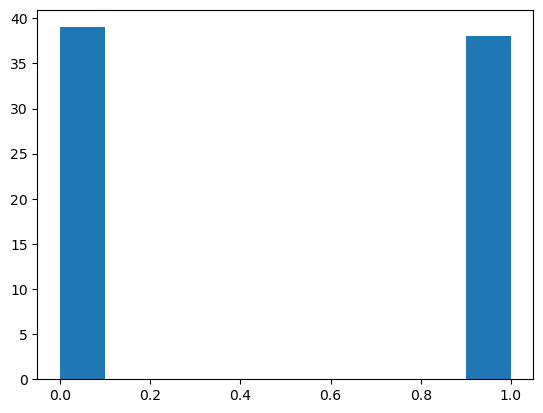

In [69]:
plt.hist([tup[1] for tup in tone_onset_DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

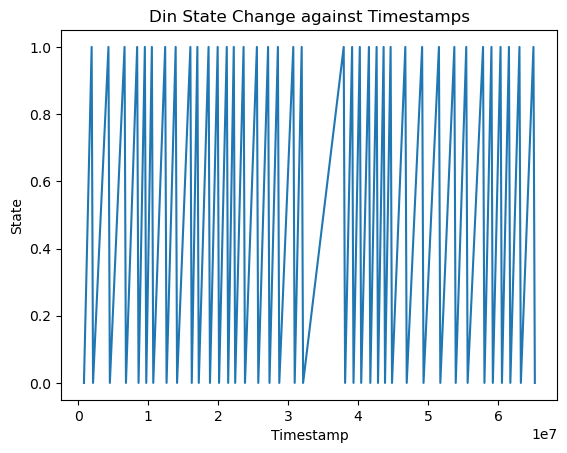

In [70]:
plt.plot([tup[0] for tup in tone_onset_DIN_state_array], [tup[1] for tup in tone_onset_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 1 Port Entries

In [81]:
box1_port_entries_DIN_state_array = file_to_data[subj_1_key]["DIO"]["dio_ECU_Din2"]["data"]

In [82]:
box1_port_entries_DIN_state_array

array([(  835680, 0), ( 1624532, 1), ( 1672532, 0), ..., (66357706, 0),
       (66382707, 1), (66383707, 0)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([652.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 651.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

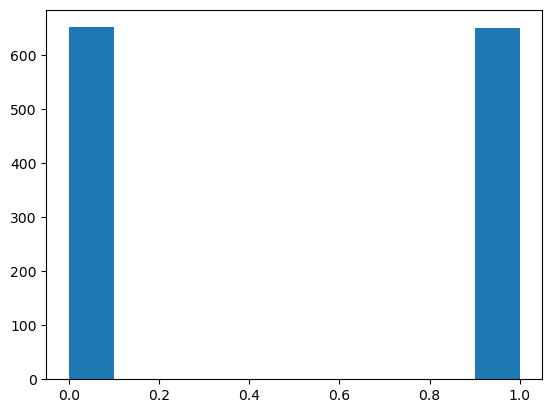

In [83]:
plt.hist([tup[1] for tup in box1_port_entries_DIN_state_array])

- There is a gap in the middle when the protocol was being changed between competition or omission

Text(0.5, 1.0, 'Din State Change against Timestamps')

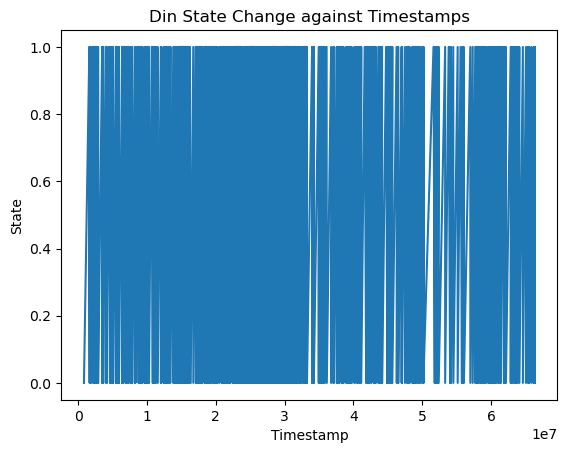

In [84]:
plt.plot([tup[0] for tup in box1_port_entries_DIN_state_array], [tup[1] for tup in box1_port_entries_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

### Box 2 Port Entries

In [91]:
box2_port_entries_DIN_state_array = file_to_data[subj_1_key]["DIO"]["dio_ECU_Din3"]["data"]

(array([1134.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1133.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

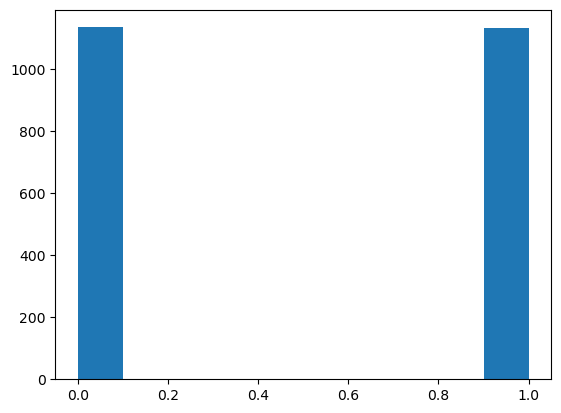

In [92]:
plt.hist([tup[1] for tup in box2_port_entries_DIN_state_array])

- This is half the time than the previous port entries, because the mouse was moved to box 1 for half of the session

Text(0.5, 1.0, 'Din State Change against Timestamps')

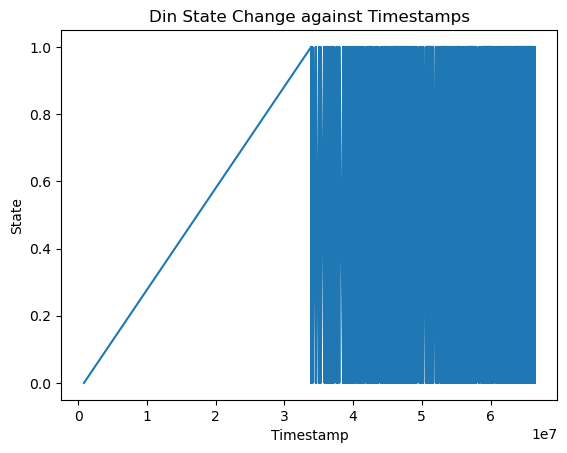

In [93]:
plt.plot([tup[0] for tup in box2_port_entries_DIN_state_array], [tup[1] for tup in box2_port_entries_DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

## Labeling the Tone and Port Entries

# Syncing with MED-PC

- List of when the ECU has changed signal. 1 means that the ECU Din1 signal is on, 0 means it's off.

In [94]:
tone_onset_DIN_state_array

array([(  835680, 0), ( 1934930, 1), ( 2134930, 0), ( 4334936, 1),
       ( 4534932, 0), ( 6634931, 1), ( 6834928, 0), ( 8434930, 1),
       ( 8634927, 0), ( 9534930, 1), ( 9734927, 0), (10534929, 1),
       (10734926, 0), (12434926, 1), (12634925, 0), (13934925, 1),
       (14134925, 0), (16034924, 1), (16234926, 0), (17034926, 1),
       (17234926, 0), (18634925, 1), (18834923, 0), (19934925, 1),
       (20134924, 0), (21234922, 1), (21434924, 0), (22234924, 1),
       (22434924, 0), (23634923, 1), (23834923, 0), (25534923, 1),
       (25734920, 0), (27134920, 1), (27334922, 0), (28534922, 1),
       (28734919, 0), (30734921, 1), (30934918, 0), (31934918, 1),
       (32134918, 0), (37934919, 1), (38134919, 0), (39134916, 1),
       (39334916, 0), (40234916, 1), (40434915, 0), (41534918, 1),
       (41734915, 0), (42634918, 1), (42834917, 0), (43634915, 1),
       (43834917, 0), (44634917, 1), (44834914, 0), (46734914, 1),
       (46934916, 0), (49134915, 1), (49334913, 0), (51534912,

38.5

- Checking to see if 1 or 0 is when the tone plays
    - Dividing by 20000, because we are recording at a sampling rate at 20000

In [95]:
tone_onset_DIN_state_array[0][0]

835680

In [96]:
tone_onset_DIN_state_array[0][1]

0

In [97]:
tone_onset_DIN_state_array[1][0]

1934930

In [98]:
tone_onset_DIN_state_array[1][1]

1

In [99]:
tone_onset_DIN_state_array[2][0]

2134930

In [100]:
tone_onset_DIN_state_array[2][1]

0

- So the tone starts when the state is "1"
    - This can be seen because the time from 1 to 0 is less than 60 seconds

In [101]:
first_delay = (tone_onset_DIN_state_array[1][0] - tone_onset_DIN_state_array[0][0]) / 20000

In [102]:
first_delay

54.9625

- Time difference for on >>> off

In [103]:
(tone_onset_DIN_state_array[3][0] - tone_onset_DIN_state_array[2][0]) / 20000

110.0003

- So the tone starts when the state is "2"
    - This can be seen because the time from 0 to 1 is 60 seconds, the time for one session

In [104]:
(tone_onset_DIN_state_array[2][0] - tone_onset_DIN_state_array[1][0]) / 20000

10.0

- Getting only the times when the ECU signal was on

In [105]:
tone_din_time = [din_time for din_time, din_state in tone_onset_DIN_state_array if din_state == 1]

In [106]:
len(tone_din_time)

38

In [107]:
tone_din_time[:10]

[1934930,
 4334936,
 6634931,
 8434930,
 9534930,
 10534929,
 12434926,
 13934925,
 16034924,
 17034926]

In [119]:
1099250 // 20000 *20

1080

In [120]:
3499256 // 20000 *20

3480

# From tone timestamps to voltage timestamps

In [126]:
tone_df = pd.DataFrame(tone_din_time, columns=["tone_timestamp"])

In [128]:
tone_df["tone_index"] = tone_df["tone_timestamp"] - voltage_timestamp_array[0]

In [129]:
tone_df.head()

,tone_timestamp,tone_index
0,1934930,1099250
1,4334936,3499256
2,6634931,5799251
3,8434930,7599250
4,9534930,8699250


In [142]:
rewarded_or_not = ["rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "omission", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded", "rewarded"]							

In [143]:
tone_df["rewarded_or_not"] = rewarded_or_not[:len(tone_df-1)]

In [144]:
competition_winners = [1.4,			
1.1,			
1.1,			
1.4,			
1.1,			
1.4,			
1.4,			
1.4,			
1.1,			
1.1,			 
1.1,			
1.1,			
1.1,			
1.1,			
1.1,			
1.1,			 
1.1,			
1.1,		
1.1,			
1.4]

In [145]:
competition_winners = competition_winners + [0] * 50

In [148]:
tone_df["competition_winners"] = competition_winners[:len(tone_df)]

In [149]:
voltage_timestamp_array[0]

835680

In [151]:
tone_df["condition"] = tone_df.apply(lambda x: x["competition_winners"] if x["competition_winners"] else x["rewarded_or_not"], axis=1)

In [152]:
tone_df

,tone_timestamp,tone_index,rewarded_or_not,competition_winners,condition
0,1934930,1099250,rewarded,1.4,1.4
1,4334936,3499256,rewarded,1.1,1.1
2,6634931,5799251,rewarded,1.1,1.1
3,8434930,7599250,rewarded,1.4,1.4
4,9534930,8699250,rewarded,1.1,1.1
5,10534929,9699249,rewarded,1.4,1.4
6,12434926,11599246,rewarded,1.4,1.4
7,13934925,13099245,rewarded,1.4,1.4
8,16034924,15199244,rewarded,1.1,1.1
9,17034926,16199246,rewarded,1.1,1.1


In [157]:
tone_df.to_csv("./20230618_100636_standard_comp_to_omission_D2_subj_1-4_and_1-1.tone_times.csv")

In [155]:
64199227/20000/60

53.49935583333333

In [118]:
tone_din_time - voltage_timestamp_array[0]

array([ 1099250,  3499256,  5799251,  7599250,  8699250,  9699249,
       11599246, 13099245, 15199244, 16199246, 17799245, 19099245,
       20399242, 21399244, 22799243, 24699243, 26299240, 27699242,
       29899241, 31099238, 37099239, 38299236, 39399236, 40699238,
       41799238, 42799235, 43799237, 45899234, 48299235, 50699232,
       52899234, 54599233, 56999232, 58199232, 59499229, 60699231,
       62199231, 64199227], dtype=uint32)

In [124]:
64199227 / 20000

3209.96135

In [ ]:
1099250

In [ ]:
box1_port_entries_DIN_file_name

In [112]:
voltage_timestamp_array[0]

[54,
 174,
 289,
 379,
 434,
 484,
 579,
 654,
 759,
 809,
 889,
 954,
 1019,
 1069,
 1139,
 1234,
 1314,
 1384,
 1494,
 1554,
 1854,
 1914,
 1969,
 2034,
 2089,
 2139,
 2189,
 2294,
 2414,
 2534,
 2644,
 2729,
 2849,
 2909,
 2974,
 3034,
 3109,
 3209]

# From DIN to Video

In [109]:
raise ValueError()

ValueError: 

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [108]:
DIN_state_array

NameError: name 'DIN_state_array' is not defined

In [ ]:
tone_time_stamp = [time_state[0] for time_state in DIN_state_array if time_state[1]]

In [ ]:
example_tone_time_stamp = tone_time_stamp[3]

In [ ]:
example_tone_time_stamp

- Array of the time stamp of all the frames

In [ ]:
pos_timestamp_array

- Getting the first video time stamp that is greater than the voltage time stamp

In [ ]:
current_video_frame = timestamp_to_index(current_ts=example_tone_time_stamp, ts_array=pos_timestamp_array)

In [ ]:
current_video_frame

In [ ]:
timestamp_to_index(current_ts=28625643, ts_array=pos_timestamp_array)

# Syncing up the timestamps using Pandas

## Adding the Voltage as columns

In [ ]:
voltage_timestamp_array[:5]

In [ ]:
voltage_timestamp_array.shape

In [ ]:
voltage_value_array[:5]

In [ ]:
voltage_value_array.shape

- Adding the voltage timestamps

In [ ]:
ephys_dataframe = pd.DataFrame(voltage_timestamp_array, columns=["voltage_time_stamp"])

In [ ]:
ephys_dataframe.head()

- Adding the voltage value

In [ ]:
ephys_dataframe.head()

## Adding the video data as columns

- Creating a seperate dataframe for video data first

In [ ]:
pos_timestamp_array[:5]

In [ ]:
pos_timestamp_array[-5:]

In [ ]:
video_dataframe = pd.DataFrame(pos_timestamp_array, columns=["PosTimestamp"])

In [ ]:
video_dataframe.head()

- Adding the frames which would just be the number in the list that the timestamps belongs to

In [ ]:
video_dataframe.insert(0, 'frame_number', range(1, 1 + len(video_dataframe)))

- Calculating the time within the video by dividing the frame by the fps

In [ ]:
video_dataframe["video_time"] = video_dataframe["frame_number"] / fps

In [ ]:
video_dataframe["video_seconds"] = video_dataframe["video_time"].astype(int)

In [ ]:
video_dataframe

## Combining the ephys and video dataframe into one

In [ ]:
ephy_and_video_dataframe = pd.merge(ephys_dataframe, video_dataframe, left_on='voltage_time_stamp', right_on='PosTimestamp', how="left")

In [ ]:
ephy_and_video_dataframe

In [ ]:
ephy_and_video_dataframe.columns

- There are only a small number of rows that have information for the video, because the sampling rate is much smaller. 

In [ ]:
ephy_and_video_dataframe.dropna(subset=["PosTimestamp"])

- Filling in all the blank cells with the previous rows for the video related columns into new columns. This can be used to select for all rows that correspond to something happening within the video

In [ ]:
ephy_and_video_dataframe.columns

In [ ]:
for col in ephy_and_video_dataframe.columns:
    if "filled" not in col:
        ephy_and_video_dataframe['filled_{}'.format(col)] = ephy_and_video_dataframe[col].fillna(method='ffill')


In [ ]:
ephy_and_video_dataframe['filled_PosTimestamp'] = ephy_and_video_dataframe['PosTimestamp'].fillna(method='ffill')
ephy_and_video_dataframe['filled_frame_number'] = ephy_and_video_dataframe['frame_number'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_time'] = ephy_and_video_dataframe['video_time'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_seconds'] = ephy_and_video_dataframe['video_seconds'].fillna(method='ffill')

In [ ]:
ephy_and_video_dataframe.tail()

## Adding the DIN info

In [ ]:
DIN_dataframe = pd.DataFrame(DIN_state_array)

In [ ]:
DIN_dataframe["trial_number"] = DIN_dataframe["state"].cumsum()

In [ ]:
DIN_dataframe

In [ ]:
ephy_and_video_dataframe = pd.merge(ephy_and_video_dataframe, DIN_dataframe, left_on='voltage_time_stamp', right_on='time', how="left")


In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
tone_info_dataframe = ephy_and_video_dataframe.dropna(subset=["time"]).reset_index(drop=True)

In [ ]:
tone_info_dataframe

In [ ]:
ephy_and_video_dataframe["filled_state"] = ephy_and_video_dataframe["state"].ffill()
ephy_and_video_dataframe["filled_trial_number"] = ephy_and_video_dataframe["trial_number"].ffill()

In [ ]:
ephy_and_video_dataframe.head()

In [ ]:
ephy_and_video_dataframe.tail()

In [ ]:
trial_1_df = ephy_and_video_dataframe[ephy_and_video_dataframe["filled_trial_number"] == 2]

In [ ]:
trial_1_df.head()

In [ ]:
file_to_data["raw"]

In [ ]:
recording_file_name = file_to_data["raw"]["raw_group0.dat"]["original_file"]

In [ ]:
recording_base_name = os.path.splitext(recording_file_name)[0]

In [ ]:
recording_base_name

In [ ]:
ephy_and_video_dataframe.to_csv("./proc/{}.timestamps.csv".format(recording_base_name))

In [ ]:
raise ValueError()

- Original frame number(before light turns on)

In [ ]:
current_video_frame = trial_1_df["filled_frame_number"].min()

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

# OTHER STUFF

## Getting the specific frame

In [ ]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

- Original frame number(before light turns on)

In [ ]:
corrected_video_frame = current_video_frame

- Corrected frame number(that has the light on)

In [ ]:
corrected_video_frame = current_video_frame + 2

In [ ]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


In [ ]:
_, frame = cap.read()

In [ ]:
video_file_path

In [ ]:
output_directory = "./proc"

In [ ]:
output_directory

In [ ]:
os.makedirs(output_directory, exist_ok=True)

In [ ]:
video_file_basename = os.path.basename(video_file_path)

In [ ]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [ ]:
video_file_root

In [ ]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [ ]:
current_video_seconds = corrected_video_frame / fps

In [ ]:
current_video_seconds

In [ ]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

## Looking over the video files

In [49]:
parent_directory_dict = file_to_data["."]

In [ ]:
video_time_stamp_dict = parent_directory_dict["1.videoTimeStamps.cameraHWSync"]

In [ ]:
video_time_stamp_dict

In [ ]:
video_time_stamp_dict["data"]

In [ ]:
video_time_stamp_dict["data"][:5]

In [ ]:
video_time_stamp_dict["data"][-5:]

In [ ]:
video_time_stamp_dict["data"].shape

## Video time to Video frame

### Reading in video

In [ ]:
raw_data_file_path

In [ ]:
video_file_list = glob.glob(os.path.join(raw_data_file_path, "*.mp4"))

In [ ]:
video_file_list

In [ ]:
video_file_path = "../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.fixed.mp4"

In [ ]:
# read video from file
cap = cv2.VideoCapture(video_file_path)

- Getting the number of frames per second

In [ ]:
fps = cap.get(cv2.CAP_PROP_FPS)

In [ ]:
fps

- Total number of frames

In [ ]:
total_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

In [ ]:
total_frame_count


- Calculating the length of the video by dividing the total number of frames by the fps

In [ ]:
video_length = total_frame_count / fps

In [ ]:
video_length

## Video frame to timestamp

- Getting the time stamps of the video frames
    - Each frame would correspond to each timestamp. Because the sample rate of videos is smaller than ephys recording, the number of video time stamps will be less than that of ephys recordings.

In [ ]:
video_time_stamp_dict

In [ ]:
video_time_stamp_array = np.array(video_time_stamp_dict["data"])

In [ ]:
video_time_stamp_array[:5]

In [ ]:
video_time_stamp_array[-5:]

In [ ]:
video_time_stamp_array.shape

- Getting only the first number in each tuple

In [ ]:
pos_timestamp_array = np.array([x[0] for x in video_time_stamp_array]) 

- Converting to integer to do calculations

In [ ]:
pos_timestamp_array = pos_timestamp_array.astype(int)

In [ ]:
pos_timestamp_array[:5]

In [ ]:
pos_timestamp_array[-5:]

## Time Stamp to Video Frame

In [63]:
video_time_stamp_array

NameError: name 'video_time_stamp_array' is not defined

In [ ]:
pos_timestamp_array

- Getting the index of the closest timestamp. The index corresponds to the video's frame number

In [ ]:
random_video_frame = timestamp_to_index(current_ts=pos_timestamp_array[0], ts_array=pos_timestamp_array)

In [ ]:
random_video_frame

In [ ]:
pos_timestamp_array[random_video_frame]